In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [301]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPUs available.')
    print(f'Device name: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('No GPU available, using CPU instead')

There are 1 GPUs available.
Device name: GeForce RTX 2070 Super


In [302]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

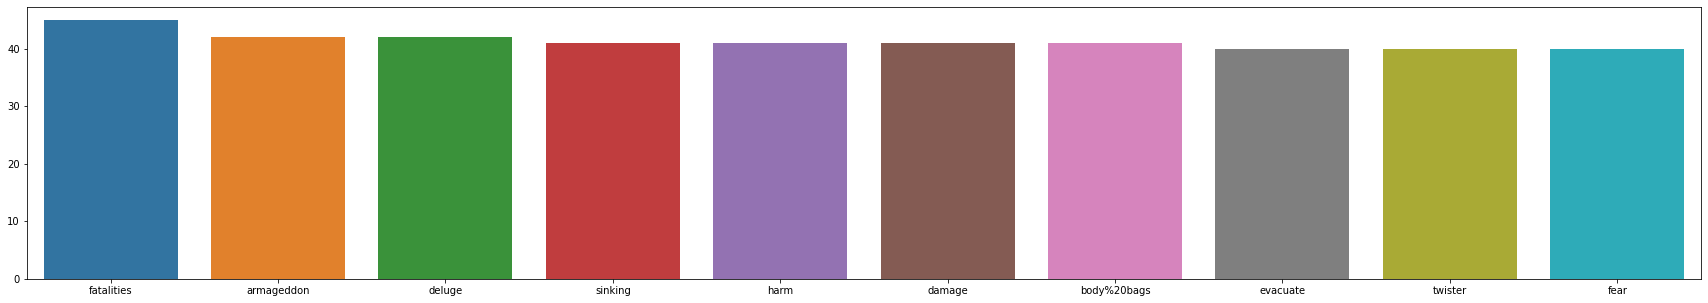

In [303]:
keyword_dist = train_df['keyword'].value_counts()

plt.figure(figsize=(30, 5))
sns.barplot(x = keyword_dist[:10].index, y = keyword_dist[:10].values)
plt.show()

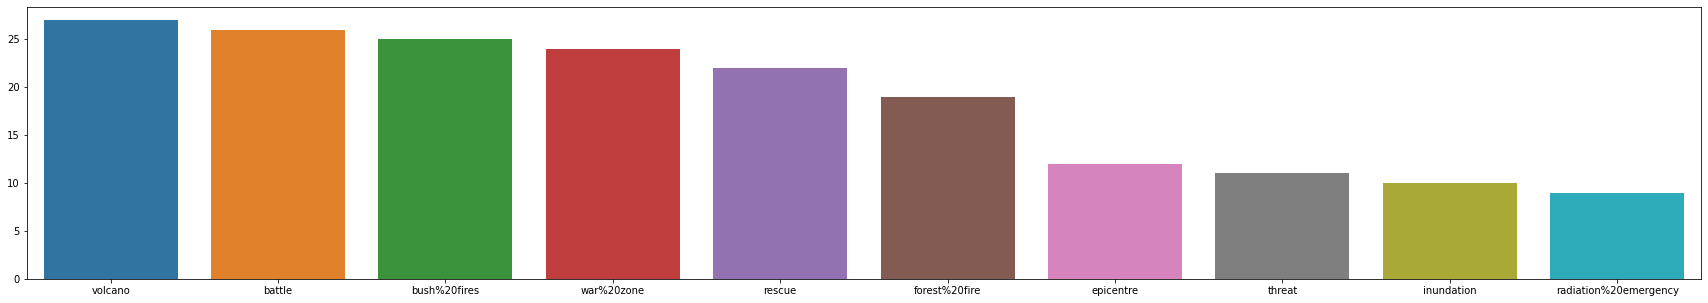

In [304]:
plt.figure(figsize=(30, 5))
sns.barplot(x = keyword_dist[-10:].index, y = keyword_dist[-10:].values)
plt.show()

In [305]:
train_df = train_df.drop(columns = ['keyword', 'location', 'id'])
test_df = test_df.drop(columns = ['keyword', 'location', 'id'])

In [306]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [307]:
import seaborn as sns

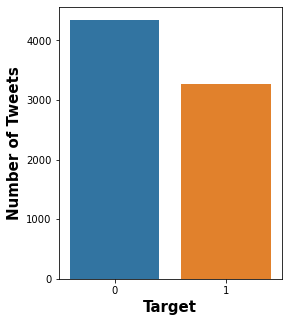

In [308]:
plt.figure(figsize=(4,5))
temp = train_df['target'].value_counts()
sns.barplot(x=temp.index, y=temp.values)
plt.xlabel("Target", weight='bold', fontsize=15)
plt.ylabel("Number of Tweets", weight='bold', fontsize=15)
plt.show()

In [309]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re

def text_processing(text):
    #convert text to lower case
    text = text.lower()
    
    #remove all the digits
    text = re.sub(r'\d+', '', text)
    
    #change 't to not
    text = re.sub(r"\'t", ' not', text)
    
    #remove @name
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    
    #remove punctuation
    text = ''.join([char for char in text if char not in punctuation])
    
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words or word in {'not', 'no','can'}])
    
    #lemmentization
    lemmatizer = WordNetLemmatizer()
    for pos in ['n', 'v', 'a']:
        text = ' '.join([lemmatizer.lemmatize(word, pos = pos) for word in text.split()])
    '''
    #stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    '''
    
    return text

In [310]:
s = train_df['text'][2]
s

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [311]:
text_processing(s)

'resident ask shelter place notify officer no evacuation shelter place order expect'

In [312]:
train_df['text'] = train_df['text'].apply(text_processing)

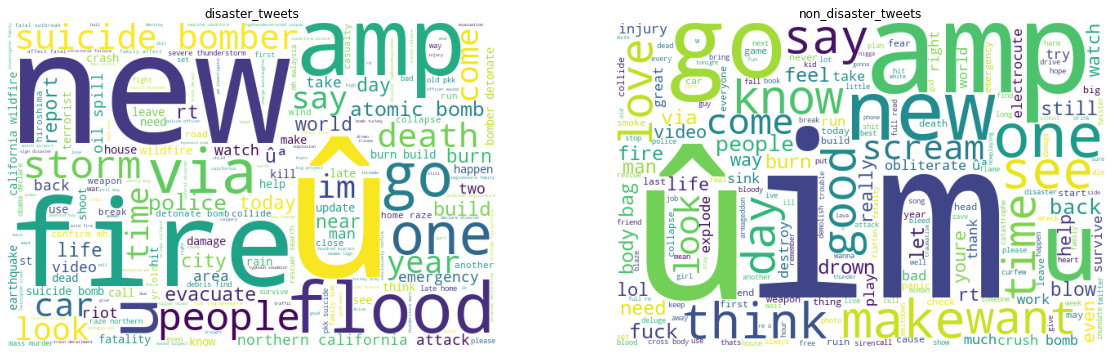

In [313]:
disaster_tweets = train_df.loc[train_df['target'] == 1]['text']
non_disaster_tweets = train_df.loc[train_df['target'] == 0]['text']

from wordcloud import WordCloud

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
wordcloud1 = WordCloud(background_color = 'white', width=600, height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title("disaster_tweets")

wordcloud2 = WordCloud(background_color = 'white', width=600, height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title("non_disaster_tweets")

plt.show()

In [314]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [315]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'], test_size=0.1, random_state = 1)

In [316]:
tfidf = TfidfVectorizer()
train_X_tfidf = tfidf.fit_transform(X_train)
val_X_tfidf = tfidf.transform(X_val)

In [232]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, auc, roc_curve, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [233]:
auc_scores = []
for a in np.arange(0.1, 10, 0.1):
    avg_auc = np.mean(cross_val_score(MultinomialNB(alpha = a), train_X_tfidf, y_train, scoring='roc_auc'))
    auc_scores.append(avg_auc)

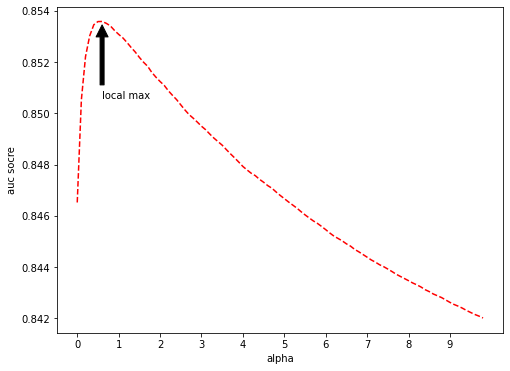

In [234]:
plt.figure(figsize=(8, 6))
plt.plot(auc_scores, 'r--')
plt.xticks(np.arange(0, 100, 10), np.arange(0, 10, 1))
plt.xlabel('alpha')
plt.ylabel('auc socre')
ymax = max(auc_scores)
xmax = auc_scores.index(ymax)
plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax-0.003),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

In [235]:
res = pd.DataFrame({'auc_score': auc_scores, 'alpha': np.arange(0.1, 10, 0.1)})
res.loc[res['auc_score'] == max(res['auc_score'])]

,auc_score,alpha
6,0.853588,0.7


In [236]:
#Evaluation on the validation set
def evaluation(prob, y_val):
    fpr, tpr, thresholds = roc_curve(y_val, prob)
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    #AUC score
    auc_score = auc(fpr, tpr)
    print(f'AUC: {auc_score}')
    
    #Accuracy
    y_hat = np.array([1 if p > thresholds[ix] else 0 for p in prob])
    acc = np.mean(y_hat == y_val)
    print(f'Accuracy: {acc}')
    
    #F-1 Score
    f1 = f1_score(y_val, y_hat)
    print(f'F1_score: {f1}')
    
    #Plot the ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='NB(alpha=0.7), AUC={0:.3f}'.format(auc_score), alpha=0.4)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='b', label='best threshold:{0:.3f}'.format(thresholds[ix]))
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    
    return thresholds[ix]

Best Threshold=0.432935, G-Mean=0.793
AUC: 0.8524790010710863
Accuracy: 0.8083989501312336
F1_score: 0.759075907590759


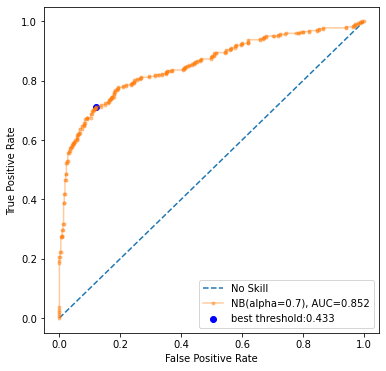

In [237]:
opt_nb = MultinomialNB(alpha=0.7)
opt_nb.fit(train_X_tfidf, y_train)
prob = opt_nb.predict_proba(val_X_tfidf)[:, 1]

best_threshold = evaluation(prob, y_val)

In [318]:
all_X = tfidf.fit_transform(train_df['text'].values)
all_y = train_df['target'].values

opt_nb = MultinomialNB(alpha=0.7)
opt_nb.fit(all_X, all_y)

MultinomialNB(alpha=0.7)

In [319]:
sample_submission = pd.read_csv('sample_submission.csv')

In [320]:
test_df['text'] = test_df['text'].apply(text_processing)

test_X_tfidf = tfidf.transform(test_df['text'])
prob = opt_nb.predict_proba(test_X_tfidf)[:, 1]
prediction = np.array([1 if p >= best_threshold else 0 for p in prob])

sample_submission['target'] = prediction

In [321]:
sample_submission.to_csv('sample_submission.csv', index=False)

In [143]:
#BERT

In [290]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [272]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPUs available.')
    print(f'Device name: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('No GPU available, using CPU instead')

There are 1 GPUs available.
Device name: GeForce RTX 2070 Super


In [394]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

train_df = train_df.drop(columns = ['keyword', 'location', 'id'])
test_df = test_df.drop(columns = ['keyword', 'location', 'id'])

In [395]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [396]:
#preprocessing
def text_preprocessing(text):
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = " ".join([word.strip() for word in text.split()])

    return text

In [397]:
def preprocessing_bert(data):
    input_ids = []
    attention_masks = []
    
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text = text_preprocessing(sent),
            add_special_tokens = True,
            max_length = MAX_LEN,
            pad_to_max_length = True,
            return_attention_mask = True
        )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

In [398]:
all_tweets = np.concatenate((train_df['text'].values, test_df['text'].values))

encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

max_len = max([len(sent) for sent in encoded_tweets])
print("Max_length: {}".format(max_len))

Max_length: 84


In [399]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'], test_size = 0.1, random_state=1)

In [400]:
MAX_LEN = 84

token_ids = list(preprocessing_bert([X_train[0]])[0].squeeze().numpy())
print('Original: {}'.format(X_train[0]))
print('Encoded: {}'.format(token_ids))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Encoded: [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


C:\Users\znan5\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [403]:
train_inputs, train_masks = preprocessing_bert(X_train)
val_inputs, val_masks = preprocessing_bert(X_val)

In [404]:
val_inputs.shape

torch.Size([762, 84])

In [405]:
train_labels, val_labels = torch.tensor(y_train.values), torch.tensor(y_val.values)

batch_size = 32

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)

val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [406]:
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, freeze_bert = False):
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )
        
        #freeze the bert parameters
        if freeze_bert:
            for param in self.bert.parameters():
                param.require_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids = input_ids, 
                           attention_mask = attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]
        
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

In [407]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_loader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [408]:
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, val_loader=None, epochs = 4, evaluation=False):
    print("Start Training...")
    min_loss, early_stopping_count = 1, 0
    
    for epoch_i in range(epochs):
        
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")
        
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        
        for step, batch in enumerate(train_loader):
            batch_counts += 1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            loss = criterion(logits, b_labels)
            batch_loss += loss
            total_loss += loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
            
            if (step % 20 == 0 and step != 0) or step == len(train_loader) - 1:
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9}")
                batch_counts, batch_loss = 0, 0
        
        avg_train_loss = total_loss/len(train_loader)
        
        print("-" * 70)
        
        if evaluation == True:
            model.eval()
            
            val_accuracy, val_loss = [], []
            
            for batch in val_loader:
                b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
                
                with torch.no_grad():
                    logits = model(b_input_ids, b_attn_mask)
                
                loss = criterion(logits, b_labels)
                val_loss.append(loss.item())
                
                preds = torch.argmax(logits, dim = 1).flatten()
                
                accuracy = (preds == b_labels).cpu().numpy().mean() * 100
                val_accuracy.append(accuracy)
            
            avg_val_accuracy = np.mean(val_accuracy)
            avg_val_loss = np.mean(val_loss)
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {avg_val_loss:^10.6f} | {avg_val_accuracy:^9.2f}")
            
            if avg_val_loss < min_loss:
                min_loss = avg_val_loss
                torch.save(model.state_dict(), "Bert_detector.pt")
                early_stopping_count = 0
            else:
                early_stopping_count += 1
            
            if early_stopping_count >= 3:
                break


In [409]:
bert_classifier, optimizer, scheduler = initialize_model(epochs = 100)
train(bert_classifier, train_loader, val_loader, epochs = 100, evaluation = True)

Start Training...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
   1    |   20    |   0.569981   |     -      |     -    
   1    |   40    |   0.462579   |     -      |     -    
   1    |   60    |   0.438153   |     -      |     -    
   1    |   80    |   0.456673   |     -      |     -    
   1    |   100   |   0.390367   |     -      |     -    
   1    |   120   |   0.437845   |     -      |     -    
   1    |   140   |   0.389232   |     -      |     -    
   1    |   160   |   0.445217   |     -      |     -    
   1    |   180   |   0.355102   |     -      |     -    
   1    |   200   |   0.376844   |     -      |     -    
   1    |   214   |   0.395779   |     -      |     -    
----------------------------------------------------------------------
   1    |    -    |   0.430469   |  0.437901  |   80.74  
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
   2    |   20    |   0.311771   |     -      |     -    
   2    |   40    |   0.279910   |     - 

In [410]:
import torch.nn.functional as F

In [411]:
def bert_prediction(model, test_loader):
    model.eval()
    
    all_logits = []
    
    for batch in test_loader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        
        all_logits.append(logits)
    
    all_logits = torch.cat(all_logits, dim = 0)
    
    probs = F.softmax(all_logits, dim = 1).cpu().numpy()
    
    return probs

In [412]:
bert, optimizer, scheduler = initialize_model()
bert.load_state_dict(torch.load("Bert_detector.pt"))

<All keys matched successfully>

In [413]:
print("Tokenizing test data")
test_inputs, test_masks = preprocessing_bert(test_df['text'])

test_dataset = TensorDataset(test_inputs, test_masks)
test_loader = DataLoader(test_dataset, batch_size = 32)

Tokenizing test data


In [414]:
probs = bert_prediction(bert, test_loader)
threshold = 0.5
preds = np.where(probs[:, 1] >= threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  1203


In [415]:
sample_submission = pd.read_csv("sample_submission.csv")

sample_submission['target'] = preds
sample_submission.to_csv("submission.csv", index = False)